In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image, ImageOps
import os
import json
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import torch.optim as optim

import cv2

import random
import numpy as np

import matplotlib.pyplot as plt


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")


Running on the GPU


In [4]:
RegressionSegmentation = 64


In [5]:
# Dataset do složky DataSet -- Dataset1
#                           |- Dataset2

# Rozdělit Dataset na 2-3 Train, Test, Validation
# Validation je až poslední
# shuffle data
# balance data nemít 40% stejnou ground truth (tohle je asi u classifierů)

#### DEFINE DataLoader ####


class data(Dataset):
    def __init__(self, path):
        self.path = path
        self.Items = []

        convert_tensor = transforms.ToTensor()
        convert_float = transforms.ConvertImageDtype(torch.float)

        self.files = os.listdir(path)

        for ML_Record in self.files:
            DatasetItem = json.load(open(os.path.join(self.path, ML_Record)))
            for i in range(0, 20):

                src = cv2.imread(DatasetItem["src"], cv2.IMREAD_GRAYSCALE)
                dst = cv2.imread(DatasetItem["dst"], cv2.IMREAD_GRAYSCALE)
                originalTransfrom = np.matrix(DatasetItem["transformation"])

                translationX = random.uniform(80, 150) * random.choice([1, -1])
                translationY = random.uniform(80, 120) * random.choice([1, -1])
                scale = random.uniform(0.8, 1.2)
                rotation = random.uniform(5, 15) * random.choice([1, -1])

                AugmentingMat = np.mat([[scale, 0.0, translationX], [0.0, scale, translationY], [0.0, 0.0, 1.0]], dtype=np.float32)
                rotationMat = cv2.getRotationMatrix2D((src.shape[1] // 2, src.shape[0] // 2), rotation, 1)
                AugmentingMat = np.matmul(np.vstack([rotationMat, [0, 0, 1]]), AugmentingMat, dtype=np.float32)

                invertedAugmentingMat = np.mat(cv2.invertAffineTransform(AugmentingMat[0:-1, :]))
                invertedAugmentingMat = np.vstack([invertedAugmentingMat, [0, 0, 1]])

                GeneratedTransform = np.matmul(originalTransfrom, invertedAugmentingMat)

                points = [
                    [0, 0, 1],
                    [1440, 1440, 1],
                    [0, 1440, 1],
                ]
                warpedPoints = np.matmul(points, GeneratedTransform.transpose(), dtype=np.float32)

                classIndexes = warpedPoints[:, 0:-1].flatten()
                classIndexes = (classIndexes + 1152) / RegressionSegmentation

                BadImage = False
                GTsegments = np.zeros((6, RegressionSegmentation))
                for i in range(0, 6):
                    idx = int((classIndexes[0, i]))
                    if idx < 0 or idx >= RegressionSegmentation:
                        print(f"FUCK: {idx}")
                        BadImage = True
                        continue
                    GTsegments[i, int((classIndexes[0, i]))] = 1

                if not BadImage:
                    warped = cv2.warpAffine(src, AugmentingMat[0:-1, :], (1440, 1440))
                    warped = cv2.resize(warped, (128, 128))
                    dst = cv2.resize(dst, (128, 128))

                    stacked = torch.stack((convert_tensor(dst), convert_tensor(warped)))
                    paths = {"src": DatasetItem["src"], "dst": DatasetItem["dst"]}
                    self.Items.append((stacked, torch.from_numpy(GTsegments.flatten()), paths))

    # the function returns length of data
    def __len__(self):
        return len(self.Items)

    # gives one item at a time
    def __getitem__(self, index):
        return self.Items[index]


In [6]:
#### DEFINE Neural Network ####
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self._to_linear = None

        # 2 input image channel, 64 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv7 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.fc9 = nn.Linear(16384, 1024)

        self.fc10 = nn.Linear(1024, RegressionSegmentation * 6)

    def convs(self, x):
        # max pooling over 2x2
        # two conv layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))

        return x

    def forward(self, x):

        x = self.convs(x)
        x = x.view(-1, x[0].shape[0] * x[0].shape[1] * x[0].shape[2])

        # two linear layers
        x = F.relu(self.fc9(x))
        x = self.fc10(x)

        return F.log_softmax(x, dim=1)


In [7]:
#### Create data ####
trainData = data(".\\..\\data03\MachineData\TrainSet")
validationData = data(".\\..\\data03\MachineData\ValidationSet")

FUCK: 66


In [8]:
#### Define parameters ####
BatchSize = 32
Epochs = 24
BatchLogCount = 2
LearningRate = 0.0001
WeightDecay = 0.01

In [9]:
from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter(f"runs/DPA_23.2_MultiplePose_Classification_v1.0.0.7 BatchSize:{BatchSize}, Epochs:{Epochs}, LearningRate:{LearningRate}, WeightDecay:{WeightDecay}")
writer = SummaryWriter(f"runs/DPA_23.2_MultiplePose_Classification_v1.0.0.10_LearningRate_{LearningRate}_WeightDecay_{WeightDecay}")

train_dataloader = DataLoader(trainData, batch_size=BatchSize, shuffle=True, drop_last=False)
val_dataloader = DataLoader(validationData, batch_size=BatchSize, shuffle=True, drop_last=False)
net = Net().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LearningRate, weight_decay=WeightDecay)

example_images, example_groundTruths, _ = iter(train_dataloader).next()
writer.add_graph(net, example_images.to(device).view(-1, 2, 128, 128))

train_set_len = len(trainData)
validation_set_len = len(validationData)
# Learning
for epoch in range(Epochs):
    running_loss = 0.0
    epoch_loss = 0.0
    batchCount = 0
    for i, dataBatch in enumerate(train_dataloader):
        Images, groundTruths, _ = dataBatch
        Images, groundTruths = Images.to(device), groundTruths.to(device)

        optimizer.zero_grad()

        outputs = net(Images.view(-1, 2, 128, 128))

        loss = loss_function(outputs, groundTruths.view(-1, RegressionSegmentation * 6))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()
        batchCount += 1

        if (i + 1) % BatchLogCount == 0:
            writer.add_scalar("Training loss", running_loss / BatchLogCount, (train_set_len * epoch) + (i * BatchSize))
            running_loss = 0.0

    # Validation
    with torch.no_grad():
        ValidationLoss = 0.0
        ValidationBatchCount = 0
        for k, (Images, groundTruths, _) in enumerate(val_dataloader):
            Images, groundTruths = Images.to(device), groundTruths.to(device)
            outputs = net(Images.view(-1, 2, 128, 128))
            loss = loss_function(outputs, groundTruths.view(-1, RegressionSegmentation * 6))
            ValidationLoss += loss.item()
            ValidationBatchCount += 1

    writer.add_scalars(f'Loss/Epoch', {
    'Validation loss': ValidationLoss / ValidationBatchCount,
    'Train loss': epoch_loss / batchCount,
    }, epoch)

    # writer.add_scalar("Validation loss / Epoch", ValidationLoss / ValidationBatchCount, epoch)
    # writer.add_scalar("Train loss / Epoch", epoch_loss / batchCount, epoch)

    print(f"Epoch: {epoch}. Train Loss: {epoch_loss / batchCount}")
    print(f"Epoch: {epoch}. Validation Loss: {ValidationLoss / ValidationBatchCount}")


Epoch: 0. Train Loss: 28.91388370225217
Epoch: 0. Validation Loss: 28.151809161063284
Epoch: 1. Train Loss: 27.478232961418527
Epoch: 1. Validation Loss: 27.049268148140982
Epoch: 2. Train Loss: 26.382520196262245
Epoch: 2. Validation Loss: 26.563553464598954
Epoch: 3. Train Loss: 25.720046997983477
Epoch: 3. Validation Loss: 26.21291934605688
Epoch: 4. Train Loss: 24.93144102302901
Epoch: 4. Validation Loss: 26.01062724390067
Epoch: 5. Train Loss: 24.014768544874983
Epoch: 5. Validation Loss: 26.152395349927247
Epoch: 6. Train Loss: 22.98677327545118
Epoch: 6. Validation Loss: 26.077183954999782
Epoch: 7. Train Loss: 21.791214238958467
Epoch: 7. Validation Loss: 26.49540901085129
Epoch: 8. Train Loss: 20.517166827121144
Epoch: 8. Validation Loss: 27.090079607034568
Epoch: 9. Train Loss: 19.19048549777889
Epoch: 9. Validation Loss: 27.693074005714152
Epoch: 10. Train Loss: 17.997166065537083
Epoch: 10. Validation Loss: 28.962138935166877
Epoch: 11. Train Loss: 16.973400718129927
Epoch:

In [10]:
iterations = []
imageCounter = 0
with torch.no_grad():
    for dataBatch in val_dataloader:
        Images, groundTruths, paths = dataBatch
        Images, groundTruths = Images.to(device), groundTruths.to(device)
        outputs = net(Images.view(-1, 2, 128, 128))

        indexes = []
        outputSegments = np.array(outputs[0].view(6, RegressionSegmentation).cpu())
        for segment in outputSegments:
            indexes.append(np.argmax(segment, axis=0))
        indexes = (np.array(indexes, dtype=np.float32) * RegressionSegmentation) - 1152
        outputPoints = indexes.reshape(3, 2)

        srcPoints = np.array(
            [
                [0, 0],
                [1440, 1440],
                [0, 1440],
            ]
        ).astype(np.float32)
        outputTransform = cv2.getAffineTransform(srcPoints, outputPoints)

        src = Images[0][1]
        src = src.cpu().detach().numpy()
        src = cv2.resize(src[0], (1440, 1440))
        warped = cv2.warpAffine(src, outputTransform, (src.shape[1], src.shape[0]))

        grayImage = np.array(warped * 255, dtype=np.uint8)

        name = paths["src"][0][10:].replace("\\", "")
        cv2.imwrite(f".\\..\\CNNAlignedImages\\Image{name}{imageCounter}.png", grayImage)

        imageCounter += 1

        loss = loss_function(outputs, groundTruths.view(-1, RegressionSegmentation * 6))
        iterations.append({"batch": dataBatch, "outputs": outputPoints, "loss": loss})


loss: 36.58325638435781
[[-320. -320.]
 [1408. 1792.]
 [-128. 1280.]]
[[ 192. -128.]
 [1280. 1792.]
 [-128. 1216.]]


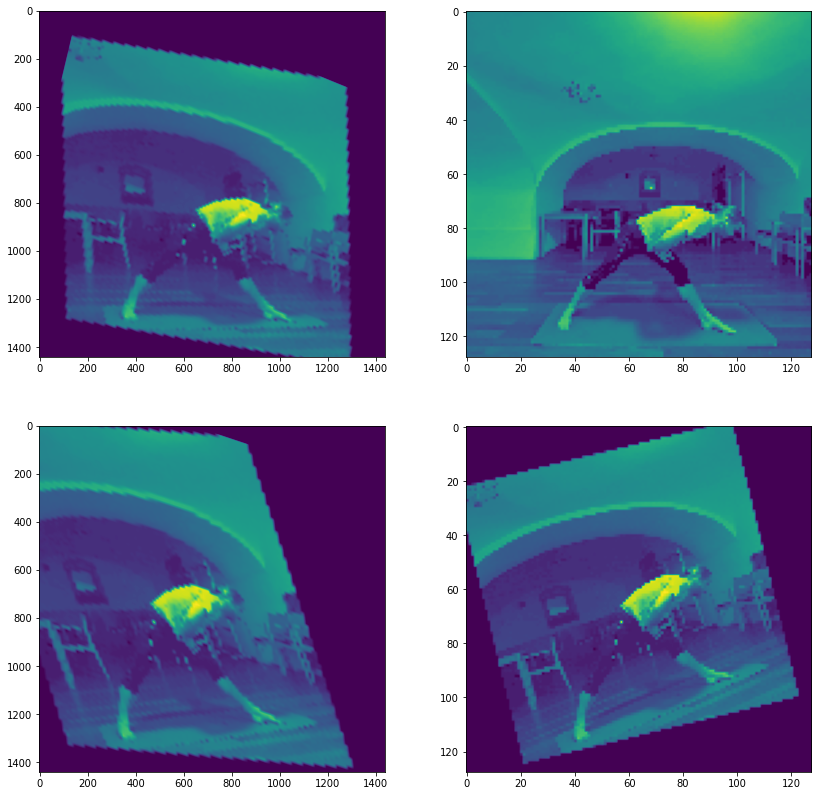

In [11]:
iteration = random.choice(iterations)
im, gt, paths = iteration["batch"]

np.set_printoptions(precision=3, suppress=True)
print(f"loss: {iteration['loss']}")

src = im[0][1]
src = src.cpu().detach().numpy()
src = cv2.resize(src[0], (1440, 1440))

dst = im[0][0]
dst = dst.cpu().detach().numpy()
dst = cv2.resize(dst[0], (1440, 1440))

indexes = []
outputSegments = np.array(gt[0].view(6, RegressionSegmentation).cpu())
for segment in outputSegments:
    indexes.append(np.argmax(segment, axis=0))
indexes = (np.array(indexes, dtype=np.float32) * RegressionSegmentation) - 1152
groundPoints = indexes.reshape(3, 2)

outputPoints = iteration["outputs"]

srcPoints = np.array(
    [
        [0, 0],
        [1440, 1440],
        [0, 1440],
    ]
).astype(np.float32)

fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Ground Truth
print(outputPoints)
print(groundPoints)

gtTransform = cv2.getAffineTransform(srcPoints, groundPoints)
warped = cv2.warpAffine(src, gtTransform, (1440, 1440))
axes[0][0].imshow(warped)

# Network Result
outputTransform = cv2.getAffineTransform(srcPoints, outputPoints)
warped = cv2.warpAffine(src, outputTransform, (1440, 1440))

axes[1][0].imshow(warped)

# Network Imputs
axes[0][1].imshow(im[0][0].view(128, 128))
axes[1][1].imshow(im[0][1].view(128, 128))


In [12]:
points = np.mat(
    [
        [0, 0, 1],
        [1440, 1440, 1],
        [0, 1440, 1],
    ]
)

print(points[:, 0:-1].flatten())
print(points[:, 0:-1])


[[   0    0 1440 1440    0 1440]]
[[   0    0]
 [1440 1440]
 [   0 1440]]
